Arima Model


In [15]:
import pandas as pd
import numpy as np
import pmdarima as pm

# Load the dataset
file = "forecasting_monthly_data.xlsx"
df = pd.read_excel(file)

# Preprocessing
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Get unique Store IDs
unique_ids = df['Store'].unique()

# List to store forecast results
results = []

# Loop through each unique Store ID and forecast
for target_id in unique_ids:
    data = df[df['Store'] == target_id].sort_index()
    data = data.drop(['Store'], axis=1)

    # Split train/test (last 1 months = test)
    if len(data) <= 12:  # Too little data to train & test
        continue

    train = data['Monthly_Sales'][:-1]
    test = data['Monthly_Sales'][-1:]#october

    # Fit ARIMA on training data
    model = pm.auto_arima(train, seasonal=False, m=1, trace=False, suppress_warnings=True,
                          start_p=0, max_p=2, start_q=0, max_q=2)

    # Forecast next 1 months (test period)
    forecast = model.predict(n_periods=1)

    # Train MAPE (in-sample prediction)
    fitted = model.predict_in_sample()
    mape_train = np.mean(np.abs((train - fitted) / train)) * 100

    # Test MAPE (against actual last 4 months)
    mape_test = np.mean(np.abs((test.values - forecast) / test.values)) * 100

    # Forecast future dates (after test)
    forecast_dates = test.index

    # Store each forecasted result

    results.append({
        'Store': target_id,
        'Forecast_Month': forecast_dates[0],   
        'Actual_Sales': test.values[0],
        'Forecasted_Sales': forecast[0],
        'Train_MAPE': round(mape_train, 2),
        'Test_MAPE': round(mape_test, 2),
        'Model_Used': 'ARIMA'
        })

# Convert to DataFrame
res_df = pd.DataFrame(results)

# Save results
res_df.to_excel("store_forecast_1months_with_train_test_mape.xlsx", index=False)

print("Forecast complete with Train & Test MAPE.")


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Forecast complete with Train & Test MAPE.


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\smrut\AppData\Local\Temp\ipykernel_19512\3840795305.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Forecasted_Sales': forecast[0],


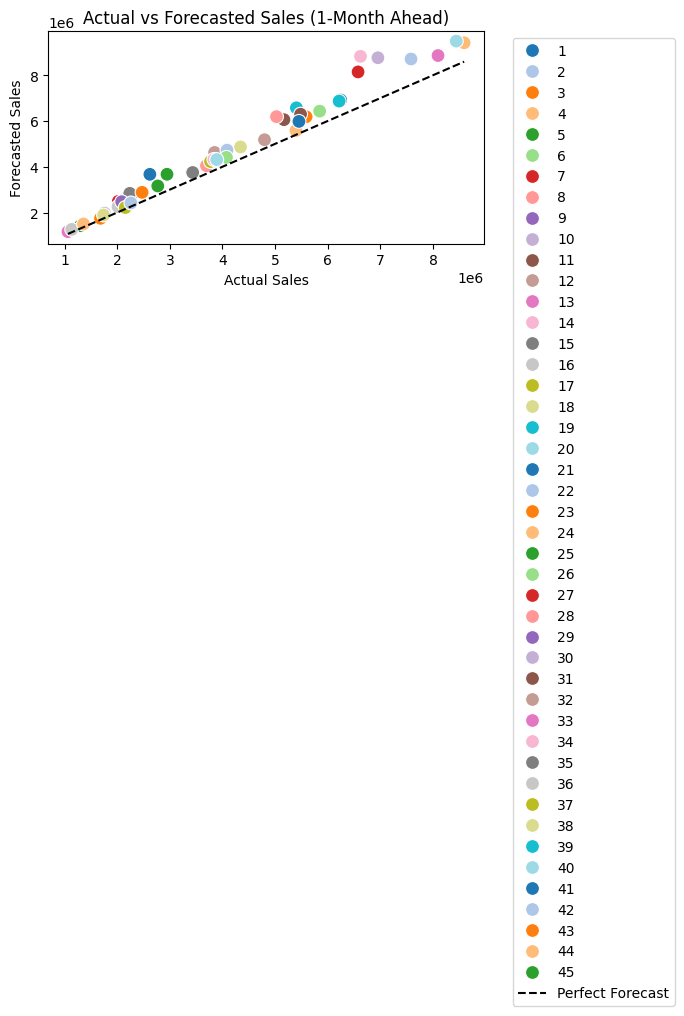

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
sns.scatterplot(data=res_df, x='Actual_Sales', y='Forecasted_Sales', hue='Store', palette='tab20', s=100)
plt.plot([res_df['Actual_Sales'].min(), res_df['Actual_Sales'].max()],
         [res_df['Actual_Sales'].min(), res_df['Actual_Sales'].max()], 'k--', label='Perfect Forecast')
plt.xlabel('Actual Sales')
plt.ylabel('Forecasted Sales')
plt.title('Actual vs Forecasted Sales (1-Month Ahead)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


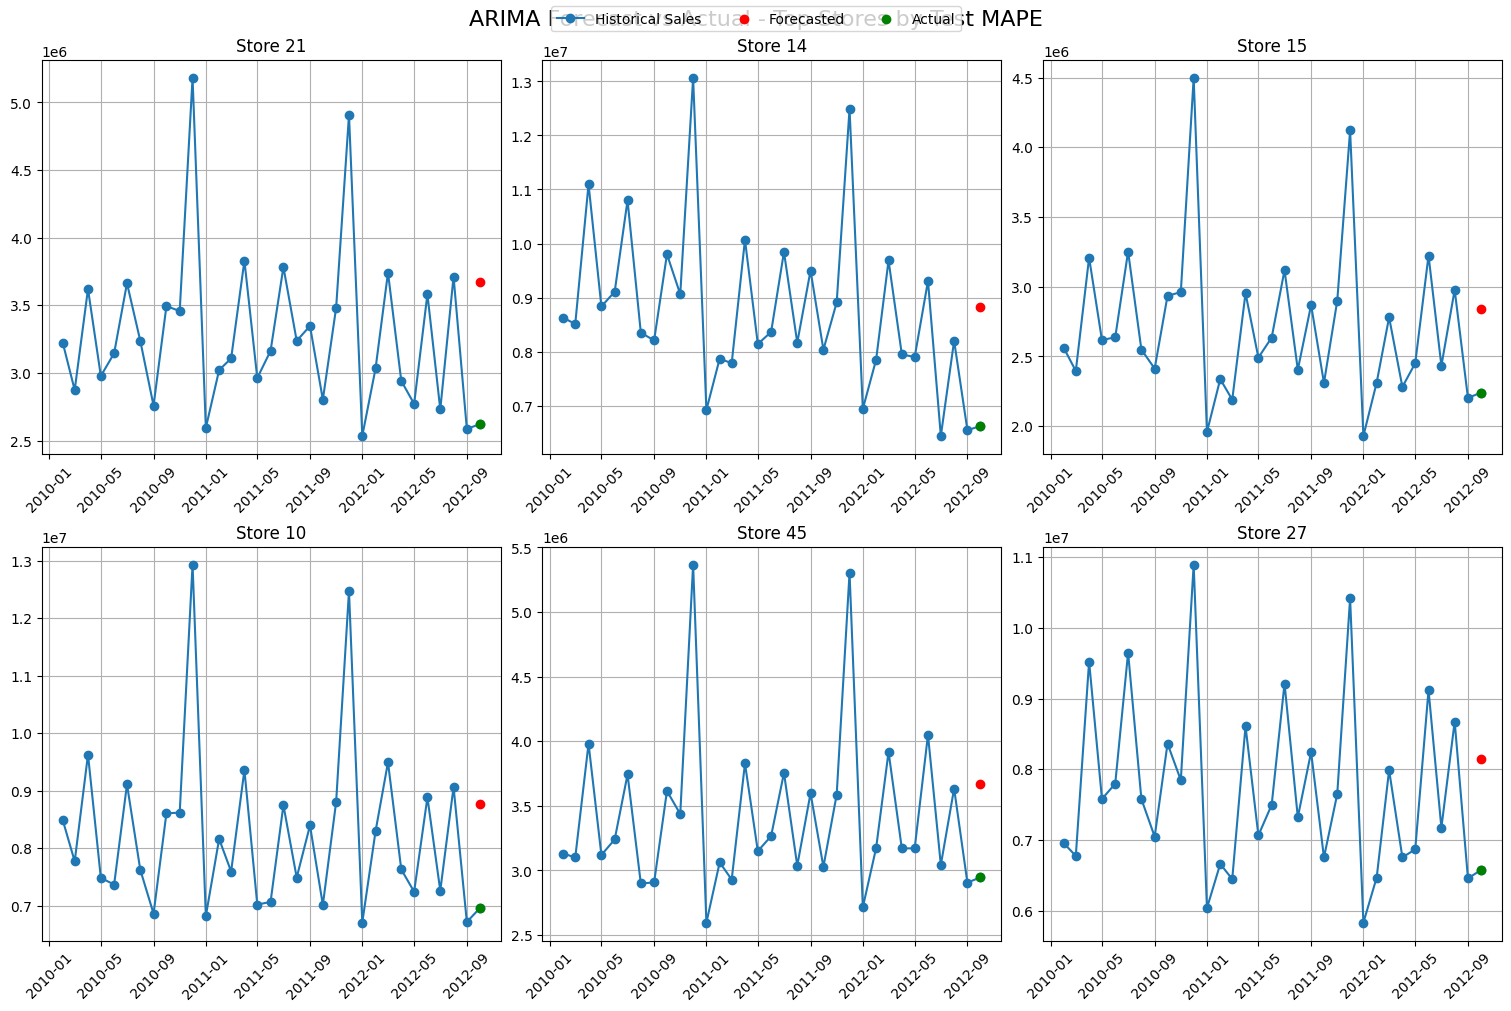

In [23]:
import matplotlib.pyplot as plt

# Select top N stores with highest test MAPE
top_n = 6
top_results = sorted(results, key=lambda x: x['Test_MAPE'], reverse=True)[:top_n]

# Setup grid layout for subplots
cols = 3
rows = (top_n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for i, result in enumerate(top_results):
    ax = axes[i]
    store = result['Store']
    forecast_month = result['Forecast_Month']
    actual = result['Actual_Sales']
    forecasted = result['Forecasted_Sales']

    # Get full historical data for the store
    store_data = df[df['Store'] == store].copy().sort_values('Month')

    # Plot historical sales
    ax.plot(store_data['Month'], store_data['Monthly_Sales'], label='Historical Sales', marker='o')

    # Plot forecasted and actual sales for the test month
    ax.scatter(forecast_month, forecasted, color='red', label='Forecasted', zorder=5)
    ax.scatter(forecast_month, actual, color='green', label='Actual', zorder=5)

    ax.set_title(f"Store {store}")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Only show legend once, outside subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

plt.suptitle("ARIMA Forecast vs Actual - Top Stores by Test MAPE", fontsize=16)
plt.show()


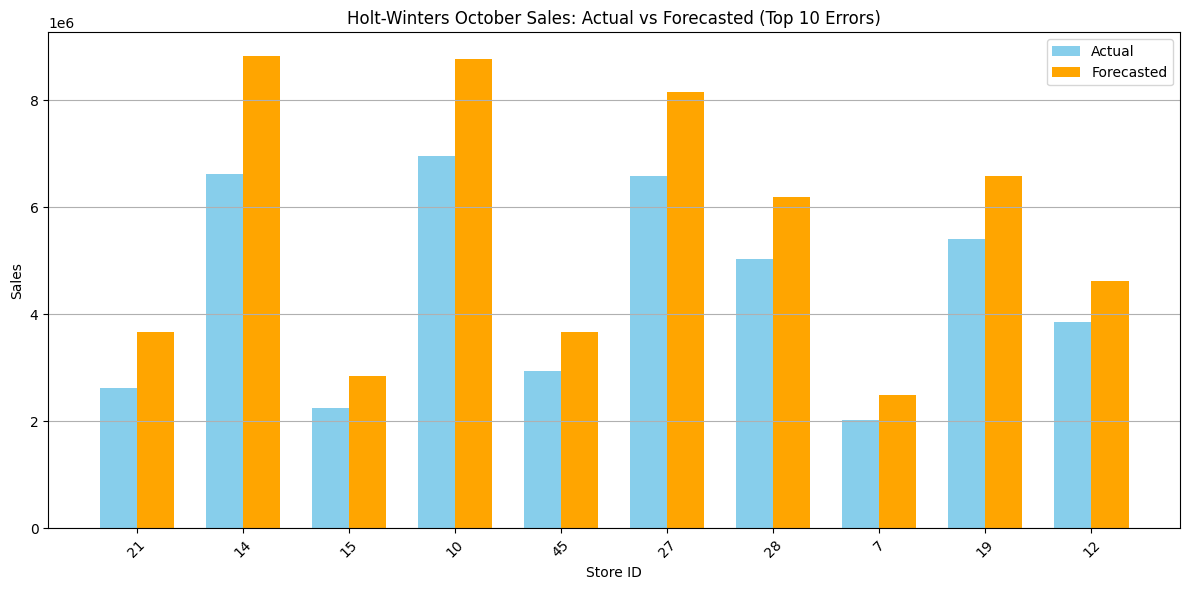

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = res_df.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'Holt-Winters October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Holtwinters Model

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

# Load data
df = pd.read_excel("forecasting_monthly_data.xlsx")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])

results1 = []

for store_id in df['Store'].unique():
    store_data = df[df['Store'] == store_id].copy()
    store_data.set_index('Month', inplace=True)
    store_data = store_data.asfreq('MS')  # Ensure monthly frequency

    # Split into training and October test
    if 10 not in store_data.index.month:
        print(f"⚠️ HW skipped Store {store_id}: No October data.")
        continue

    october = store_data[store_data.index.month == 10]
    train = store_data[store_data.index.month != 10]

    if len(train) < 6:
        print(f"⚠️ HW skipped Store {store_id}: Not enough training data.")
        continue

    try:
        model = ExponentialSmoothing(train['Monthly_Sales'], seasonal='add', seasonal_periods=12)
        fit = model.fit(optimized=True)

        # Forecast October
        forecast = fit.forecast(1).values[0]
        actual = october['Monthly_Sales'].values[0]

        # MAPE
        train_pred = fit.fittedvalues
        train_mape = mean_absolute_percentage_error(train['Monthly_Sales'], train_pred) * 100
        test_mape = mean_absolute_percentage_error([actual], [forecast]) * 100

        results1.append({
            'Store': store_id,
            'Forecast_Month': october.index[0],
            'Actual_Sales': actual,
            'Forecasted_Sales': forecast,
            'Train_MAPE': round(train_mape, 2),
            'Test_MAPE': round(test_mape, 2),
            'Model_Used': 'Holt-Winters'
        })

    except Exception as e:
        print(f"⚠️ HW failed for Store {store_id}: {e}")
        continue

# Export results
forecast_df1 = pd.DataFrame(results1)
forecast_df1.to_excel("hw_october_forecast.xlsx", index=False)
print("✅ Holt-Winters October forecasting complete.")

C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction

✅ Holt-Winters October forecasting complete.


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

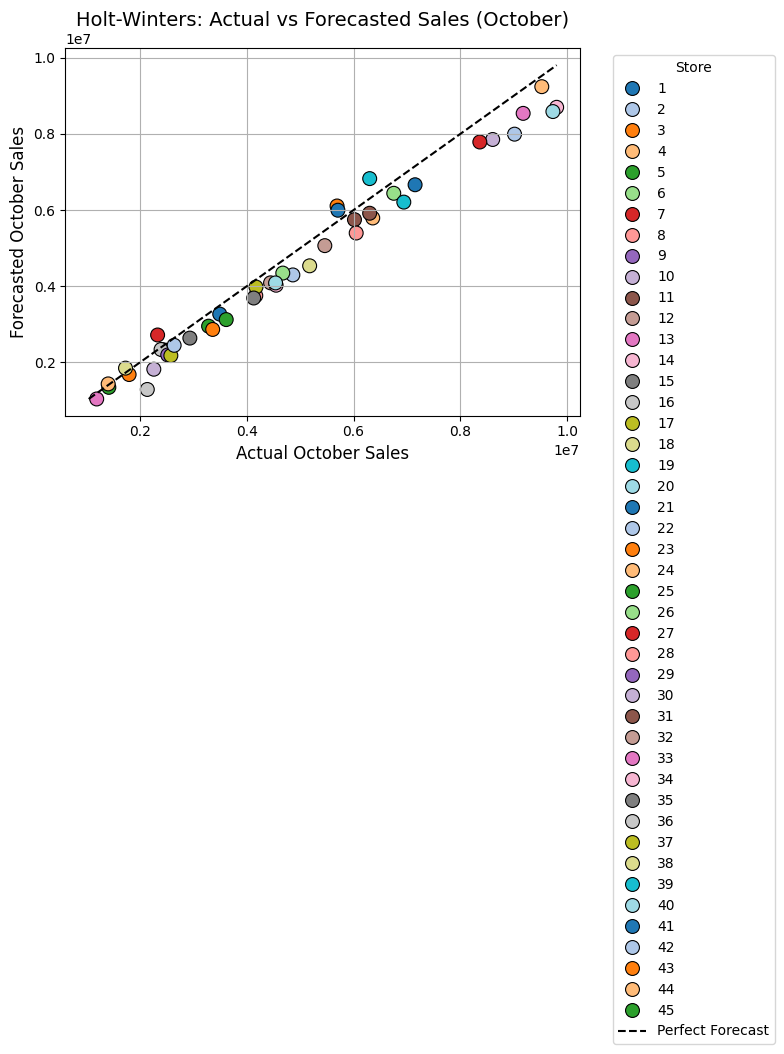

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))

# Scatter plot
sns.scatterplot(
    data=forecast_df1,
    x='Actual_Sales',
    y='Forecasted_Sales',
    hue='Store',
    palette='tab20',
    s=100,
    edgecolor='black'
)

# Diagonal line for perfect prediction
min_val = min(forecast_df1['Actual_Sales'].min(), forecast_df1['Forecasted_Sales'].min())
max_val = max(forecast_df1['Actual_Sales'].max(), forecast_df1['Forecasted_Sales'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Forecast')

plt.xlabel('Actual October Sales', fontsize=12)
plt.ylabel('Forecasted October Sales', fontsize=12)
plt.title('Holt-Winters: Actual vs Forecasted Sales (October)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Store')
plt.grid(True)
plt.tight_layout()
plt.show()


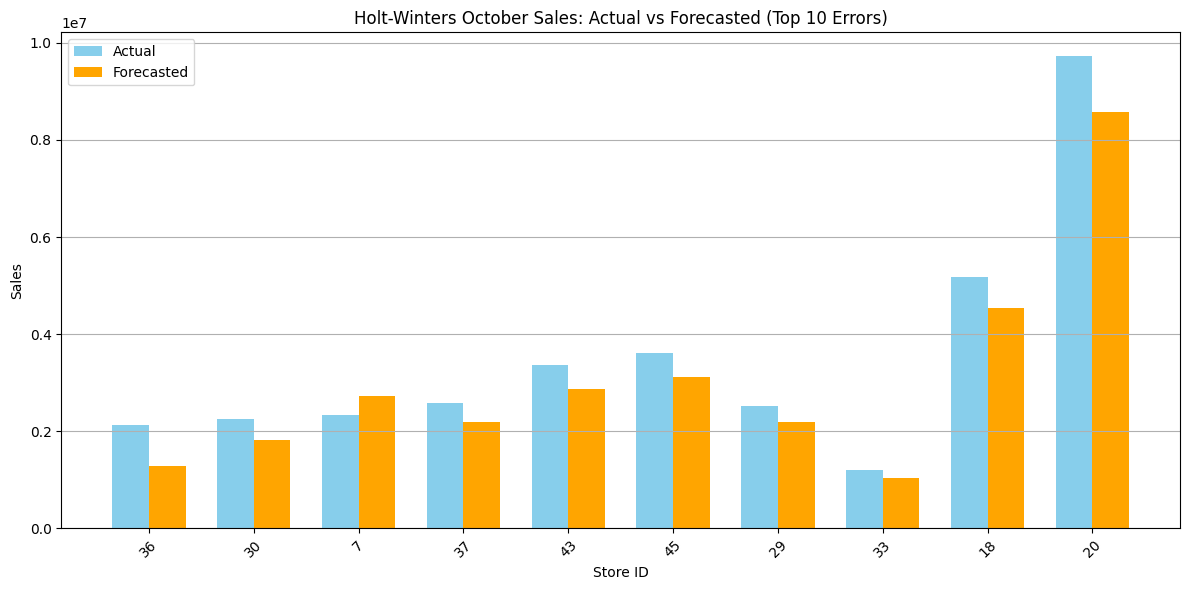

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = forecast_df1.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'Holt-Winters October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


UCM Model

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_percentage_error

# Load dataset
df = pd.read_excel("forecasting_monthly_data.xlsx")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])

results2 = []

# Loop through each store
for store_id in df['Store'].unique():
    store_data = df[df['Store'] == store_id].sort_values('Month')

    # Must have at least 12 months of data
    if len(store_data) < 12:
        print(f"Skipping Store {store_id} — not enough data.")
        continue

    store_data.set_index('Month', inplace=True)
    sales = store_data['Monthly_Sales']

    # Use all data except last month for training
    train_series = sales.iloc[:-1]
    test_value = sales.iloc[-1]
    test_date = sales.index[-1]

    try:
        # Seasonal model if enough data, else non-seasonal
        if len(train_series) >= 24:
            model = UnobservedComponents(train_series, level='local level', seasonal=12)
        else:
            model = UnobservedComponents(train_series, level='local level')

        result = model.fit(disp=False)

        # Forecast 1 step ahead (test)
        forecast = result.forecast(steps=1)[0]
        test_mape = mean_absolute_percentage_error([test_value], [forecast]) * 100

        # In-sample fitted values for train MAPE
        fitted_values = result.fittedvalues
        train_mape = mean_absolute_percentage_error(train_series, fitted_values) * 100

        results2.append({
            'Store': store_id,
            'Forecast_Month': test_date,
            'Actual_Sales': test_value,
            'Forecasted_Sales': forecast,
            'Train_MAPE': round(train_mape, 2),
            'Test_MAPE': round(test_mape, 2),
            'Model_Used': 'UCM'
        })

    except Exception as e:
        print(f"⚠️ UCM failed for Store {store_id}: {e}")

# Export results
forecast_df2 = pd.DataFrame(results2)
forecast_df2.to_excel("ucm_forecast_with_mape.xlsx", index=False)

print("✅ UCM forecasting with Train and Test MAPE complete.")


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\smrut\AppData\Local\Temp\ipykernel_19512\2954681910.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = result.forecast(steps=1)[0]
C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\smrut\AppData\Local\Temp\ipykernel_19512\2954681910.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as label

✅ UCM forecasting with Train and Test MAPE complete.


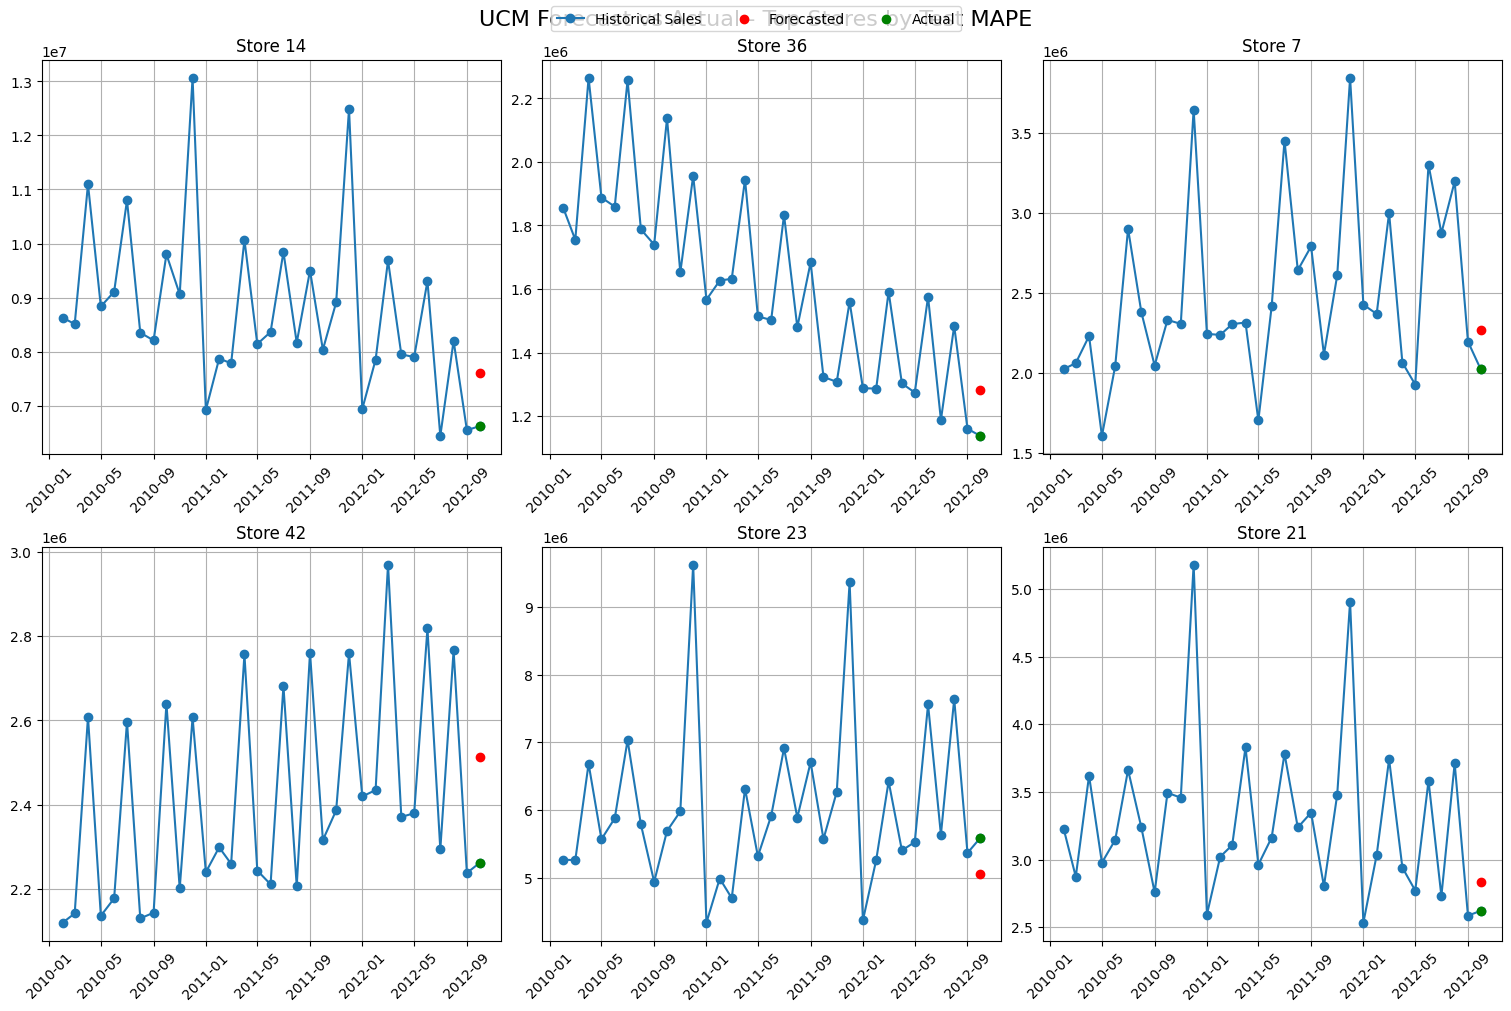

In [21]:
import matplotlib.pyplot as plt

# Select top N stores to display
top_n = 6
top_results = sorted(results2, key=lambda x: x['Test_MAPE'], reverse=True)[:top_n]

cols = 3
rows = (top_n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for i, result in enumerate(top_results):
    ax = axes[i]
    store = result['Store']
    forecast_month = result['Forecast_Month']
    actual = result['Actual_Sales']
    forecasted = result['Forecasted_Sales']
    store_data = df[df['Store'] == store].copy().sort_values('Month')

    ax.plot(store_data['Month'], store_data['Monthly_Sales'], label='Historical Sales', marker='o')
    ax.scatter(forecast_month, forecasted, color='red', label='Forecasted', zorder=5)
    ax.scatter(forecast_month, actual, color='green', label='Actual', zorder=5)
    ax.set_title(f"Store {store}")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Show legend only once
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

plt.suptitle("UCM Forecast vs Actual - Top Stores by Test MAPE", fontsize=16)
plt.show()


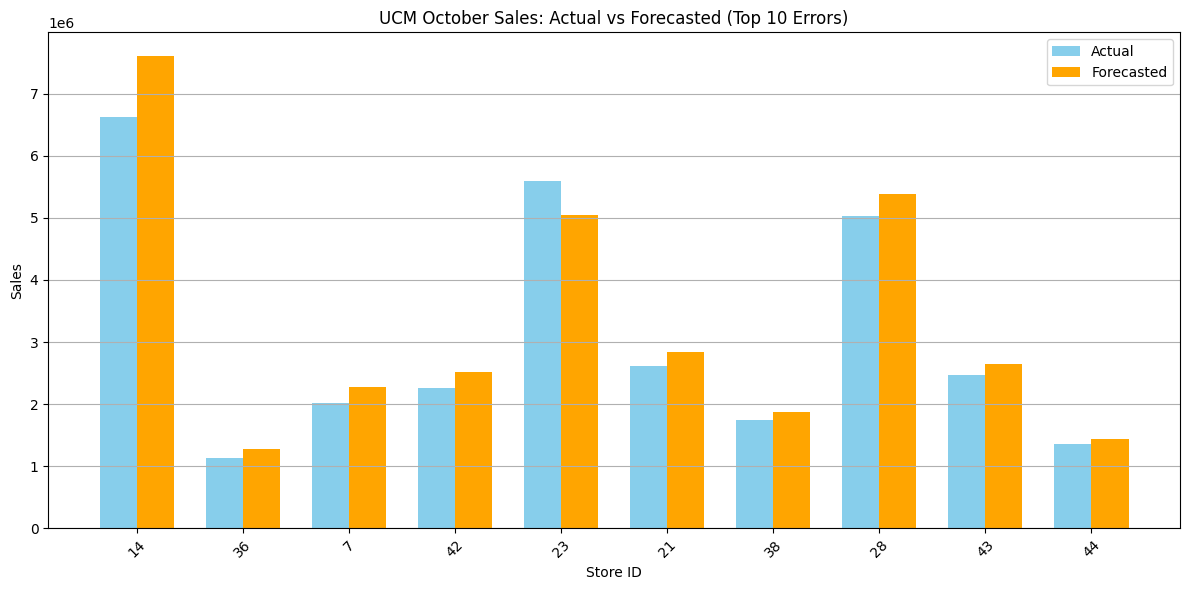

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = forecast_df2.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'UCM October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

df = pd.read_excel("forecasting_monthly_data.xlsx")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])
unique_ids = df['Store'].unique()
results4 = []
# Function to prepare LSTM input
def prepare_lstm_input(series, time_step, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    else:
        scaled = scaler.transform(series.values.reshape(-1, 1))
    X = [scaled[-time_step:]]
    return np.array(X).reshape(1, time_step, 1), scaler
# Loop through each store
for store_id in unique_ids:
    store_data = df[df['Store'] == store_id].copy().sort_values('Month')

    # Extract October row (month == 10) as test, rest as training
    october_row = store_data[store_data['Month'].dt.month == 10]
    train_data = store_data[store_data['Month'].dt.month != 10]

    if october_row.empty or len(train_data) < 4:
        print(f"Skipping Store {store_id} — not enough training data or no October.")
        continue

    # Prepare series
    train_series = train_data.set_index('Month')['Monthly_Sales']
    actual_oct = october_row['Monthly_Sales'].values[0]
    oct_month = october_row['Month'].values[0]

    # Time step for LSTM input
    time_step = min(len(train_series), 3)

    # Prepare training data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    X_train, y_train = [], []
    for i in range(time_step, len(scaled)):
        X_train.append(scaled[i-time_step:i, 0])
        y_train.append(scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], time_step, 1)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0, callbacks=[early_stop])

    # Prepare input and forecast October
    input_seq = train_series[-time_step:]
    X_pred, _ = prepare_lstm_input(input_seq, time_step, scaler)
    forecast_scaled = model.predict(X_pred)
    forecast = scaler.inverse_transform(forecast_scaled)[0][0]

    # Calculate Train MAPE
    train_preds_scaled = model.predict(X_train)
    train_preds = scaler.inverse_transform(train_preds_scaled)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    train_mape = mean_absolute_percentage_error(y_train_inv, train_preds) * 100

    # Test MAPE (October)
    test_mape = np.mean(np.abs((actual_oct - forecast) / actual_oct)) * 100

    results4.append({
        'Store': store_id,
        'Forecast_Month': pd.to_datetime(oct_month),
        'Actual_Sales': actual_oct,
        'Forecasted_Sales': forecast,
        'Train_MAPE': round(train_mape, 2),
        'Test_MAPE': round(test_mape, 2),
        'Model_Used': 'LSTM'
    })

# Save results
forecast_df3 = pd.DataFrame(results4)
forecast_df3.to_excel("lstm_october_forecast_with_mape.xlsx", index=False)

print("LSTM October forecasting with Train & Test MAPE complete.")

C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


C:\Users\smrut\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
✅ LSTM October forecasting with Train & Test MAPE complete.


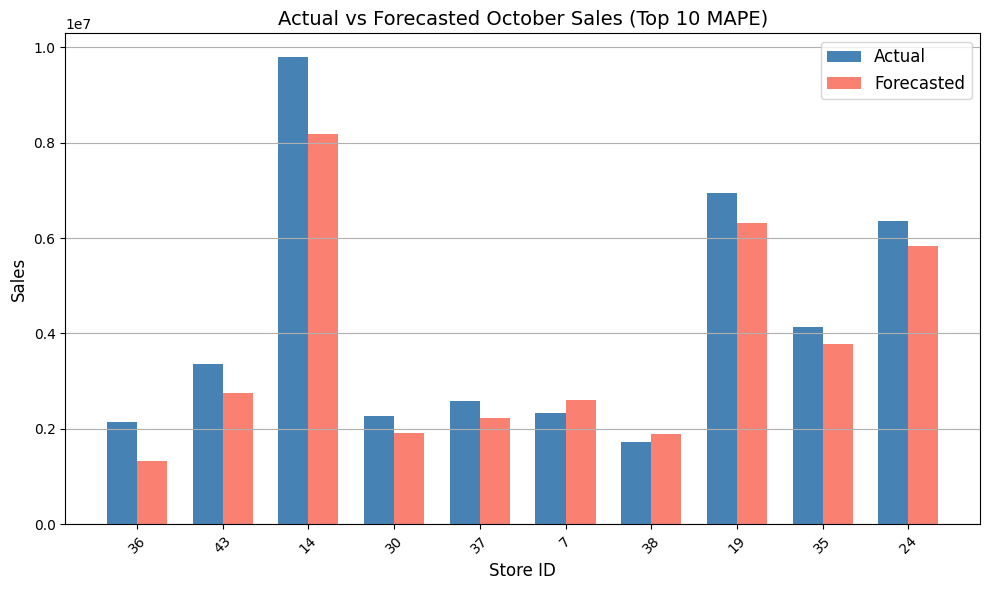

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Limit to top N stores by test MAPE
top_n = 10
plot_df = forecast_df3.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))  # Store positions
width = 0.35

# Adjust figure size to fit everything on one page
plt.figure(figsize=(10, 6))

# Bar plot for Actual and Forecasted Sales
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='steelblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='salmon')

# Adjust tick labels and other styling for readability
plt.xticks(x, plot_df['Store'], rotation=45, fontsize=10)
plt.ylabel('Sales', fontsize=12)
plt.xlabel('Store ID', fontsize=12)
plt.title(f'Actual vs Forecasted October Sales (Top {top_n} MAPE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()

# Show the plot
plt.show()